#**SHM on open-source Aging Bridge Dataset from Kaggle : using very basic ML to predict degradation score**
Here's a link to the kaggle dataset : [Link to Kaggle Dataset](https://www.kaggle.com/datasets/programmer3/aging-bridge-shm-time-series-dataset)

> This is the most crude basic implementation - haven't considered the time series and not fine-tuned yet

In [32]:
#import necessary libraries
import pandas as pd #for working with dataframes (tables)
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for static visualizations
import seaborn as sns #built on top of matplotlib - provides high-level interface for statistical graphics

#import necessary functions from certain modules/libraries
from sklearn.model_selection import train_test_split #to split dataset into training and testing sets for ML model
from sklearn.ensemble import RandomForestRegressor #ML algo for predicting continuous values
#from xgboost import XGBRegressor
#from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error #some evaluation metrics

In [33]:
#load dataset
df = pd.read_csv('synthetic_bridge_dataset.csv')

#display the first 5 rows of the dataset
print("\nDataframe Head:")
print(df.head())



Dataframe Head:
             timestamp bridge_id sensor_id  acceleration_x  acceleration_y  \
0  2020-01-01 00:00:00      B003        S3        0.275774        0.058900   
1  2020-01-01 01:00:00      B001        S3        0.305760        0.361480   
2  2020-01-01 02:00:00      B002        S3       -0.027868        0.219445   
3  2020-01-01 03:00:00      B002        S2        0.391314        0.223808   
4  2020-01-01 04:00:00      B002        S3        0.053108       -0.242146   

   acceleration_z  temperature_c  humidity_percent  wind_speed_mps  \
0       -0.286847      20.140688         33.038169       11.660055   
1       -0.306415      33.571636         57.169039        9.062089   
2       -0.057793      18.147125         30.058922        5.420342   
3        0.028680      20.202335         46.296330        7.321010   
4        0.045990      22.109588         55.982737       14.605329   

   fft_peak_freq  fft_magnitude  degradation_score  structural_condition  \
0       0.667870 

###**brief breakdown of the columns (features) in given dataset :**
* `timestamp`: date and time of the sensor reading
* `bridge_id`: identifier for the bridge
* `sensor_id`: identifier for the sensor on the bridge
* `acceleration_x`, `acceleration_y`, `acceleration_z`: Acceleration readings along the x, y, and z axes. *These indicate vibrations and movements of the bridge*

* `temperature_c`: temperature in Celsius. *Temperature can affect material properties and cause expansion or contraction*

* `humidity_percent`: relative humidity

* `wind_speed_mps`: wind speed (in meters per second)

* `fft_peak_freq`: peak frequency from a Fast Fourier Transform of the vibration data. *This indicates the natural frequency of the bridge (which can change as the structure degrades)*

* `fft_magnitude`: magnitude of the peak frequency

* `degradation_score`: we'll consider this our target variable. A numerical score representing the level of degradation (higher score means more degradation)

* `structural_condition`: categorical rating of the bridge's condition

* `damage_class`: categorical label for the damage level (e.g., 'No Damage', 'Minor', 'Severe')

* `forecast_score_next_30d`: forecasted degradation score for the next 30 days

In [34]:
#display basic information about the dataset
print("Dataframe Info:")
df.info()

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                5000 non-null   object 
 1   bridge_id                5000 non-null   object 
 2   sensor_id                5000 non-null   object 
 3   acceleration_x           5000 non-null   float64
 4   acceleration_y           5000 non-null   float64
 5   acceleration_z           5000 non-null   float64
 6   temperature_c            5000 non-null   float64
 7   humidity_percent         5000 non-null   float64
 8   wind_speed_mps           5000 non-null   float64
 9   fft_peak_freq            5000 non-null   float64
 10  fft_magnitude            5000 non-null   float64
 11  degradation_score        5000 non-null   float64
 12  structural_condition     5000 non-null   int64  
 13  damage_class             5000 non-null   object 
 14  forecast

*in the above output we can observe there are no null values in the dataset - this is a plus (if there were null values present, we'd have to handle these: common techniques are deleting the rows with null values or filling the null values with column average, and so on)*

In [35]:
#display summary statistics
print("Dataframe Description:\n")
print(df.describe())

Dataframe Description:

       acceleration_x  acceleration_y  acceleration_z  temperature_c  \
count     5000.000000     5000.000000     5000.000000    5000.000000   
mean         0.007518       -0.009071       -0.008463      25.181279   
std          0.281770        0.291860        0.304895       5.010550   
min         -0.872300       -1.148754       -0.901086       7.199972   
25%         -0.191048       -0.210725       -0.211038      21.683375   
50%          0.013405        0.000867       -0.007055      25.212843   
75%          0.203448        0.190429        0.200165      28.633939   
max          0.958277        0.918312        1.022132      41.531937   

       humidity_percent  wind_speed_mps  fft_peak_freq  fft_magnitude  \
count       5000.000000     5000.000000    5000.000000    5000.000000   
mean          59.941672        7.658783       2.732781       0.808912   
std           17.585074        4.320980       1.278692       0.398632   
min           30.055872        0.00

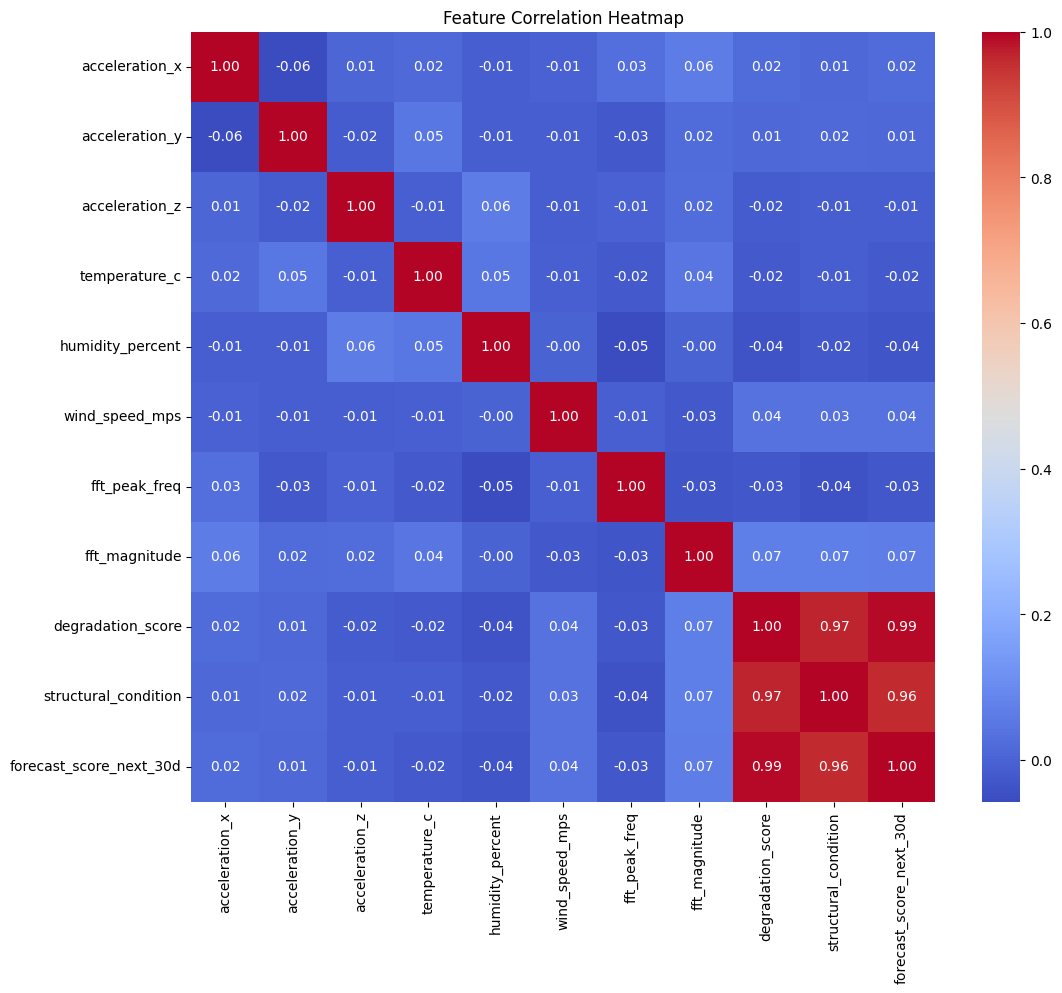

In [36]:
#feature correlation
#we'll select only numeric columns for correlation matrix for now
numeric_cols = df.select_dtypes(include=np.number).columns
correlation_matrix = df[numeric_cols].corr()

#plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Heatmap')
plt.show()

###**ML model for degradation score prediction**

In [37]:
#feature engineering and selection
df_ml = df.copy() #made a copy of the original dataframe to work on

#encode categorical variables
df_ml = pd.get_dummies(df_ml, columns=['bridge_id', 'sensor_id', 'damage_class'], drop_first=True)

#drop 'timestamp' for this model
#we'll also drop 'structural_condition' and 'forecast_score_next_30d' (these are dependedent on our target variable degradation_score so we won't consider these for training)
df_ml = df_ml.drop(['timestamp', 'structural_condition', 'forecast_score_next_30d'], axis=1)

In [38]:
#define features (X) and target (y)
X = df_ml.drop('degradation_score', axis=1) #all features except degradation_score
y = df_ml['degradation_score']

#split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#initialize and train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

#make predictionsa
y_pred = model.predict(X_test)

In [39]:
#evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"\nModel Performance:")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


Model Performance:
R-squared: 0.9676
Mean Absolute Error: 3.3087
Root Mean Squared Error: 4.1509


* **R-squared** (R2): Represents the percentage of the target variable's variance that the model can explain. A score closer to 1.0 indicates a better fit.

* **Mean Absolute Error** (MAE): This is the average absolute difference between the predicted and actual values. It's easy to interpret because it's in the same units as the target variable. A lower value is better.

* **Root Mean Squared Error** (RMSE): This is the square root of the average of squared errors. It's also in the same units as the target but penalizes large errors (outliers) much more heavily than MAE. A lower value is better.

###**Visualizations**

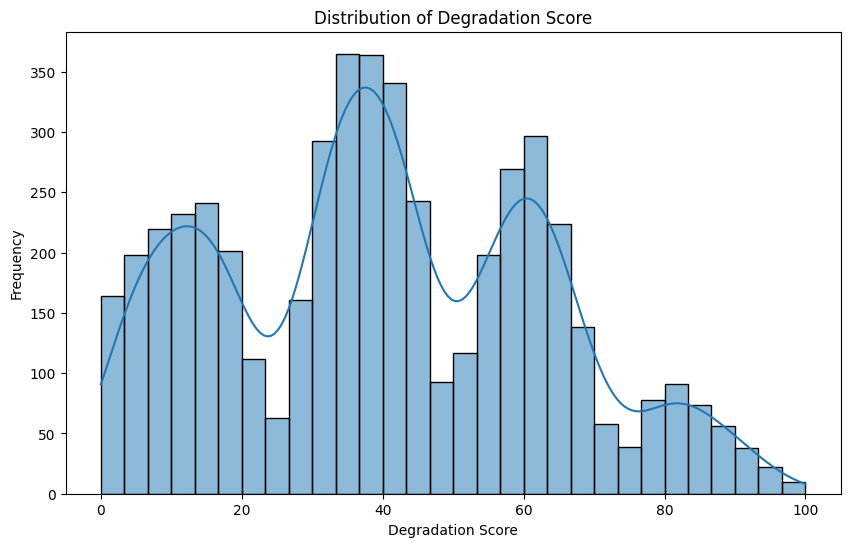

In [40]:
#distribution of degradation score
plt.figure(figsize=(10, 6))
sns.histplot(df['degradation_score'], kde=True, bins=30)
plt.title('Distribution of Degradation Score')
plt.xlabel('Degradation Score')
plt.ylabel('Frequency')
plt.show()

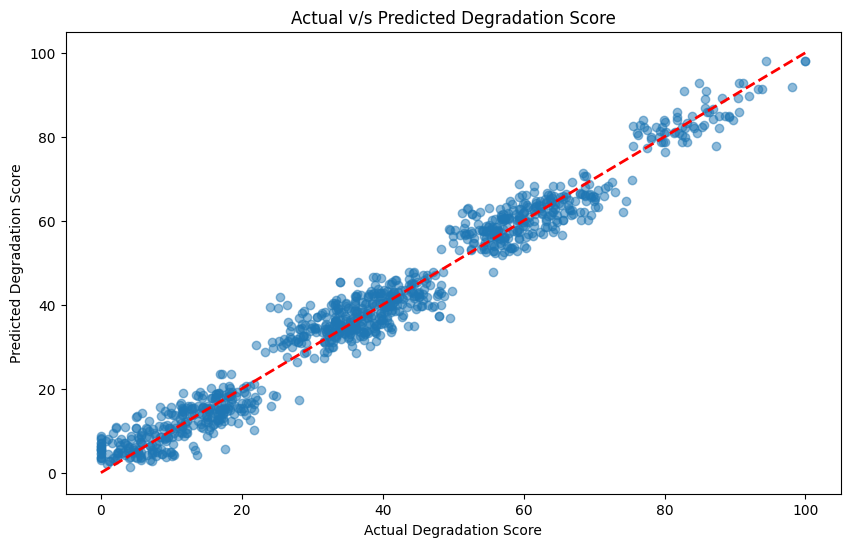

In [41]:
#actual v/s predicted degradation score
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.title('Actual v/s Predicted Degradation Score')
plt.xlabel('Actual Degradation Score')
plt.ylabel('Predicted Degradation Score')
plt.show()